<a href="https://colab.research.google.com/github/killerbeelsl/weather_temperature_prediction_with_transformer/blob/main/data_preprocessing_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.imputation import MeanMedianImputer

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used.


In [ ]:
df = pd.read_csv('drive/MyDrive/data/final_data.csv')
df = df.sort_values(by=['ID', 'YEAR', 'MONTH'])

In [ ]:
df

,ID,YEAR,MONTH,DMFLAG,QCFLAG,LATITUDE,LONGITUDE,STNELEV,Temperature
0,ACW00011604,1961,1,NaN,NaN,57.7667,11.8667,18.0,-0.78
1,ACW00011604,1961,2,NaN,NaN,57.7667,11.8667,18.0,2.47
2,ACW00011604,1961,3,NaN,NaN,57.7667,11.8667,18.0,4.83
3,ACW00011604,1961,4,NaN,NaN,57.7667,11.8667,18.0,7.84
4,ACW00011604,1961,5,NaN,NaN,57.7667,11.8667,18.0,11.39
...,...,...,...,...,...,...,...,...,...
499995,ASN00034002,2006,4,E,NaN,-20.0781,146.2614,309.8,24.87
499996,ASN00034002,2006,5,E,NaN,-20.0781,146.2614,309.8,21.31
499997,ASN00034002,2006,6,E,NaN,-20.0781,146.2614,309.8,18.69
499998,ASN00034002,2006,7,E,NaN,-20.0781,146.2614,309.8,18.09


In [ ]:
df = df[:500000]

In [ ]:
# Remove rows where 'VALUE' is -9999
df = df[df['Temperature'] != -99.99]

In [ ]:
data = df.copy()

In [ ]:
lag_features = ['Temperature']  # Features to create lags for
lags = [1, 2, 3]  # Lag periods (1 month, 2 months, 3 months)

lag_transformer = LagFeatures(variables=lag_features, periods=lags)
data = lag_transformer.fit_transform(data)  # Apply to your DataFrame

# Impute with the mean
imputer = MeanMedianImputer(imputation_method='mean', variables=[f'Temperature_lag_{lag}' for lag in lags])
data = imputer.fit_transform(data)

In [ ]:
# 1. Scale numerical features
scaler = MinMaxScaler()
numerical_features = ['LATITUDE', 'LONGITUDE', 'STNELEV']+ [f'Temperature_lag_{lag}' for lag in lags]
# data[numerical_features] = scaler.fit_transform(data[numerical_features])

unchanged_features = ['YEAR', 'MONTH']


In [ ]:
value_scaler = MinMaxScaler()
value_transformed = value_scaler.fit_transform(data['Temperature'].values.reshape(-1, 1)).reshape(-1)

In [ ]:
# 2. One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sparse=False for array output
categorical_features = ['DMFLAG', 'QCFLAG']  # Include 'ID' for station embeddings
encoded_features = encoder.fit_transform(data[categorical_features])

In [ ]:
data = data.drop(columns=['Temperature'])

In [ ]:
data.head()

,ID,YEAR,MONTH,DMFLAG,QCFLAG,LATITUDE,LONGITUDE,STNELEV,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3
0,ACW00011604,1961,1,NaN,NaN,57.7667,11.8667,18.0,19.615665,19.615668,19.61567
1,ACW00011604,1961,2,NaN,NaN,57.7667,11.8667,18.0,-0.780000,19.615668,19.61567
2,ACW00011604,1961,3,NaN,NaN,57.7667,11.8667,18.0,2.470000,-0.780000,19.61567
3,ACW00011604,1961,4,NaN,NaN,57.7667,11.8667,18.0,4.830000,2.470000,-0.78000
4,ACW00011604,1961,5,NaN,NaN,57.7667,11.8667,18.0,7.840000,4.830000,2.47000


In [ ]:
X = np.concatenate([data[unchanged_features].values,encoded_features,
                   data[numerical_features].values], axis=1)
y = value_transformed  # Target variable

In [ ]:
num_features = X[1].shape[0]

In [ ]:
num_features

13

In [ ]:
# --- Sequence creation ---
sequence_length = 12  # Example sequence length (12 months)

X_sequences = []
y_sequences = []
for i in range(sequence_length, len(X)):
    X_sequences.append(X[i - sequence_length:i])
    y_sequences.append(y[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42
)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.1, random_state=42
)

In [ ]:
batch_size = 32
num_epochs = 10

In [ ]:
# --- Create PyTorch Datasets and DataLoaders ---
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))


train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [ ]:
# --- Define the Transformer model ---
class TransformerModel(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(num_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer,
 num_layers)
        self.decoder = nn.Linear(d_model, 1)  # Output layer for temperature prediction

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Take the output from the last time step
        return output


In [ ]:
# --- Model instantiation and training ---
model = TransformerModel(num_features=X_train.shape[2], d_model=512, nhead=8, num_layers=6, dim_feedforward=2048).to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# --- Validation loop ---
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to calculate gradients during validation
        for src, target in val_loader:
            src = src.to(device)
            target = target.to(device)
            output = model(src)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [ ]:
# --- Evaluation ---
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for src, target in test_loader:
            src = src.to(device)
            target = target.to(device)
            output = model(src)
            loss = criterion(output, target)
            total_loss += loss.item()
            all_predictions.extend(output.tolist())  # Store predictions
            all_targets.extend(target.tolist())  # Store true values

    # Calculate evaluation metrics (e.g., RMSE)
    rmse = np.sqrt(np.mean((np.array(all_predictions) - np.array(all_targets))**2))
    return total_loss / len(test_loader), rmse

In [ ]:
# --- Training loop with validation ---
for epoch in range(num_epochs):
    # Training loop
  for src, target in train_loader:
      src = src.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      output = model(src)
      loss = criterion(output, target)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Clip gradients
      optimizer.step()
  val_loss = validate(model, val_loader, criterion)
  print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, tar

Epoch [1/10], Validation Loss: 0.0158
Epoch [2/10], Validation Loss: 0.0156
Epoch [3/10], Validation Loss: 0.0155
Epoch [4/10], Validation Loss: 0.0155
Epoch [5/10], Validation Loss: 0.0156
Epoch [6/10], Validation Loss: 0.0156
Epoch [7/10], Validation Loss: 0.0155
Epoch [8/10], Validation Loss: 0.0155
Epoch [9/10], Validation Loss: 0.0155
Epoch [10/10], Validation Loss: 0.0155


In [ ]:
# Assuming 'model' is your trained PyTorch model
torch.save(model.state_dict(), 'tensorflow_model.pth')  # Replace with your desired path

In [ ]:
# --- Final evaluation ---
test_loss, rmse = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, RMSE: {rmse:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.0156, RMSE: 0.1247


In [ ]:
original_min = value_scaler.data_min_[0]
original_max = value_scaler.data_max_[0]

In [ ]:
original_min, original_max

(-16.57, 40.2)

In [ ]:
original_rmse = rmse * (original_max - original_min) + original_min

In [ ]:
original_rmse

-9.48799331164037

Prediction of Unknown data

In [ ]:
new_data = pd.read_csv('2010_data.csv')

In [ ]:
new_data = new_data.sort_values(by=['ID', 'YEAR', 'MONTH'])

In [ ]:
new_data = new_data[:100]

In [ ]:
new_data

,ID,YEAR,MONTH,DMFLAG,QCFLAG,LATITUDE,LONGITUDE,STNELEV,NAME,Temperature
0,ACW00011604,2010,1,NaN,NaN,57.7667,11.8667,18.0,SAVE,-5.48
722,ACW00011604,2010,2,NaN,NaN,57.7667,11.8667,18.0,SAVE,-3.49
1444,ACW00011604,2010,3,NaN,NaN,57.7667,11.8667,18.0,SAVE,1.90
2166,ACW00011604,2010,4,NaN,NaN,57.7667,11.8667,18.0,SAVE,7.19
2888,ACW00011604,2010,5,NaN,NaN,57.7667,11.8667,18.0,SAVE,11.27
...,...,...,...,...,...,...,...,...,...,...
7949,AFM00040911,2010,12,E,NaN,36.7000,67.2000,378.0,MAZAR_I_SHARIF,5.69
8,AFM00040938,2010,1,NaN,NaN,34.2100,62.2280,977.2,HERAT,7.81
730,AFM00040938,2010,2,NaN,NaN,34.2100,62.2280,977.2,HERAT,8.81
1452,AFM00040938,2010,3,NaN,NaN,34.2100,62.2280,977.2,HERAT,14.60


In [ ]:
lag_features = ['Temperature']  # Features to create lags for
lags = [1, 2, 3]  # Lag periods (1 month, 2 months, 3 months)

lag_transformer = LagFeatures(variables=lag_features, periods=lags)
new_data = lag_transformer.fit_transform(new_data)  # Apply to your DataFrame

# Impute with the mean
imputer = MeanMedianImputer(imputation_method='mean', variables=[f'Temperature_lag_{lag}' for lag in lags])
new_data = imputer.fit_transform(new_data)

In [ ]:
# Assuming 'model' is an instance of your model class
model.load_state_dict(torch.load('tensorflow_model.pth'))
model.eval()  # Set to evaluation mode for inference

<ipython-input-137-d8caa4d04ff6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tensorflow_model.pth'))


TransformerModel(
  (embedding): Linear(in_features=13, out_features=512, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features

In [ ]:
# prompt: write a code to predict the temperature of new_data frame, do all the pre-processing needed, remove the temperature feature before passing to the model

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# ... (rest of your existing code)

def predict_temperature(new_data_df, model, scaler, encoder, value_scaler, original_min, original_max,device):
    """
    Predicts temperature for a new DataFrame.
    """

    # Preprocess the new data
    # new_data_df[numerical_features] = scaler.transform(new_data_df[numerical_features])
    encoded_new_features = encoder.transform(new_data_df[categorical_features])
    new_data_df = new_data_df.drop(columns=['Temperature']) # assuming 'VALUE' exists in the new data as well
    new_X = np.concatenate([new_data_df[unchanged_features].values,encoded_new_features,
                   new_data_df[numerical_features].values], axis=1)

    # Create sequences from the new data
    X_new_sequences = []
    for i in range(sequence_length, len(new_X)):
      X_new_sequences.append(new_X[i - sequence_length:i])

    X_new_sequences = np.array(X_new_sequences)


    # Convert to PyTorch tensor
    X_new_tensor = torch.Tensor(X_new_sequences).to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():

        new_predictions = model(X_new_tensor).cpu().tolist()

    # Inverse transform the predictions
    new_predictions_original_scale = np.array(new_predictions) * (original_max - original_min) + original_min

    return new_predictions_original_scale

# Example usage:
new_predictions = predict_temperature(new_data.copy(), model, scaler, encoder, value_scaler, original_min, original_max,device)
new_predictions = new_predictions.tolist()


In [ ]:
new_pred  = [0.0]*12 + [x[0] for x in new_predictions]

In [ ]:
len(new_pred)

100

In [ ]:
df = new_data.reset_index(drop=True)

In [ ]:
df["Predicted Temperature"] = pd.Series(new_pred)

In [ ]:
df

,ID,YEAR,MONTH,DMFLAG,QCFLAG,LATITUDE,LONGITUDE,STNELEV,NAME,Temperature,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3,Predicted Temperature
0,ACW00011604,2010,1,NaN,NaN,57.7667,11.8667,18.0,SAVE,-5.48,24.968485,25.015408,25.048144,0.000000
1,AE000041196,2010,1,NaN,NaN,25.3330,55.5170,34.0,SHARJAH_INTER_AIRP,19.14,-5.480000,25.015408,25.048144,0.000000
2,AEM00041184,2010,1,NaN,NaN,25.6170,55.9330,31.0,RAS_AL_KHAIMAH_INTE,19.14,19.140000,-5.480000,25.048144,0.000000
3,AEM00041194,2010,1,NaN,NaN,25.2550,55.3640,10.4,DUBAI_INTL,20.89,19.140000,19.140000,-5.480000,0.000000
4,AEM00041216,2010,1,E,NaN,24.4300,54.4700,3.0,ABU_DHABI_BATEEN_AIR,20.09,20.890000,19.140000,19.140000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AEM00041194,2010,12,NaN,NaN,25.2550,55.3640,10.4,DUBAI_INTL,22.30,20.350000,20.520000,-6.150000,19.155598
96,AEM00041216,2010,12,NaN,NaN,24.4300,54.4700,3.0,ABU_DHABI_BATEEN_AIR,21.71,22.300000,20.350000,20.520000,19.155598
97,AEM00041217,2010,12,NaN,NaN,24.4330,54.6510,26.8,ABU_DHABI_INTL,21.84,21.710000,22.300000,20.350000,19.155598
98,AEM00041218,2010,12,NaN,NaN,24.2620,55.6090,264.9,AL_AIN_INTL,20.37,21.840000,21.710000,22.300000,19.155598


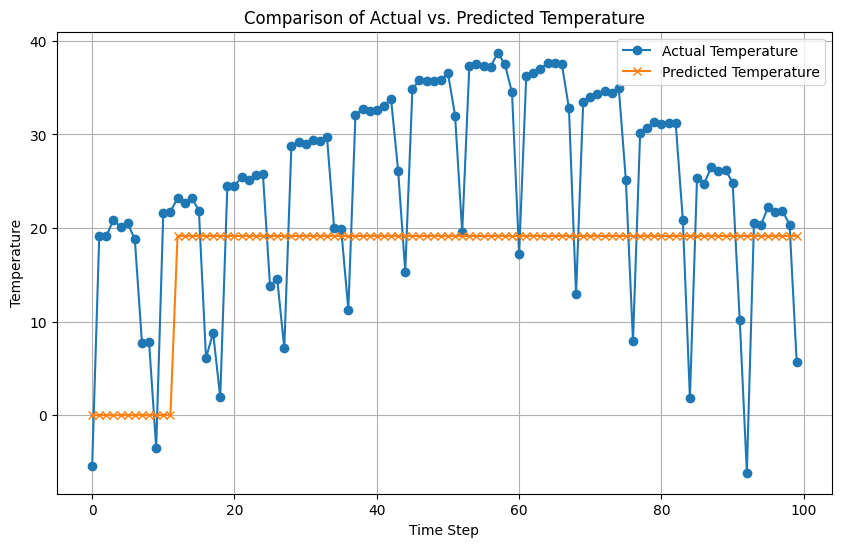

In [ ]:
# prompt: create a plot to show the comparison between Temperature and predicted temperature

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'Temperature' and 'Predicted Temperature' columns
plt.figure(figsize=(10, 6))
plt.plot(df['Temperature'][:100], label='Actual Temperature', marker='o')
plt.plot(df['Predicted Temperature'][:100], label='Predicted Temperature', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Comparison of Actual vs. Predicted Temperature')
plt.legend()
plt.grid(True)
plt.show()